## Problem Statment

Special Teams are **tricky** to evaluate. Splashy plays are **hard** to come by. Take for example that...

   I. Around **1.2 - 1.4%** of blocks are blocked per year
   
   II. **0.5** of punts are returned for a touchdown
   
  III. On average, each team punts around **3.7** times a game. **22%** of those are touchbacks. Not many chances for returns! 
  
**So how do we evaluate special team players if their impact is ambiguous?**. 

Some special teams metrics are clear. For example, punter accuracy, % of field goals made, accuracy of long snapper, or most # of tackles.

But this does not account for the hard-work the rest of the team does to ensure success...  
From the **gunner** forcing the returner into traffic, to the **rusher** pressuring the punter to change his kick trajectory, to the **personal protector**, making the right read on a overload, or the **winger** correctly moving into his assigned lane preventing a big return. My goal is to figure out ways to compare the **indirect** production of special teamers.

## Solution

Let's step into the shoes of a **punt rusher**. There are 2 parts:

    1) Disrupting the punter
    
    2) Containing the kicking team, post punt.

There are also **trade-offs** to be made:

    1) The type of rush: Bull/Finesse
    
    2) The direction of the rush
    
    2) Not overextending!
    
    3) Or, faking the rush to contain the kicking team
    
This is more complicated than playing defensive-end because there are inherently **two parts** the rusher has to play: **disrupter** & **container**. We should measure both how a player **disrupts** the punter, and how they **contain** their man.

I propose two ELO based ratings:

    1) Rush ELO

    2) Contain ELO

**Why ELO ratings?**

ELO ratings can capture how a player does versus the **expected outcome** and **relative** to others. For example, if player X on the kicking team is known to be uncontainable, and player Y held them longer than average, then player Y rating should have a higher rating than those who coudn't contain player X.

And, with the **two proposed ratings** above, we have their sister metrics for the kicking team:

    1) Rush ELO <--> Block ELO

    2) Contain ELO <--> Shed ELO

The intricacies of the calculation will be elaborated on next. I'll expand on how to use these metrics to (1) **find undervalued players**, who might not directly produce, but add lots of value on special teams, and (2) make **better personal decsiions** based off the reward/risk trade-off with any given special teams match-up.

# 1. Rush ELO/Block ELO

For Rush ELO, I wanted to model the **disruption** made to the punter, not just punt blocks. I realized the relationship is **not linear** i.e 1 yard from the punter indicates high disruption, but there is probably litte difference in punter disruption from 4 yards onwards. Therefore, I chose to regress with **log(x)** .

The log model takes in: 

    1) Closest Defender Distance To Punter

    2) Line Of Scrimmage

And predicts: playResult i.e the yards gained in total by the punt.

Below, we graph the **closest defender distance** on x to **playResult mean** on y. You can see this graph gives off logarithmic regression energy.

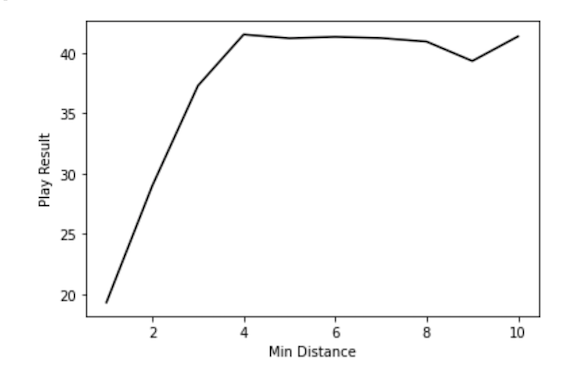


I take this model, and calculate the **distance of each rusher** from the punter right before & during the kick. We take the minimum distance for each player, filter those who didn't reach within 10 yards of the punter (i.e containment players like vises) and pass values through our model, to get **predicted yards**, a proxy for ELO outcome (i.e dosen't need to be exact, as long as it captures the relative relationshp)

**ELO Rating Formula**

We use a **ELO match up** between rusher and blocker. This is the formula:

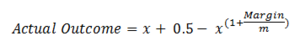

We calculate **expected outcome** by:

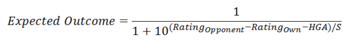

Actual Outcome is calculated by **minmax scaling** the model output of predicted yards. Due to using minmax scaling + log combo, on average, rushers will get a **25%** actual outcome and blockers will get **75%**. For the **initizilization of ratings**, I adjusted the ratings so the expectations match the mean outcome. We run match-ups multiple times till relative ELO ratings **converge**.

Here are the **top 10** rushers:

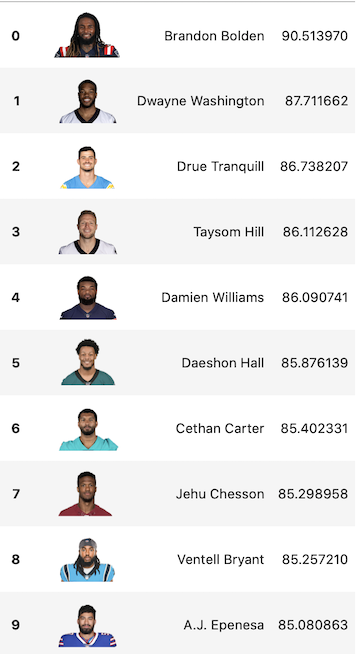

Here are the **top 10** blockers:

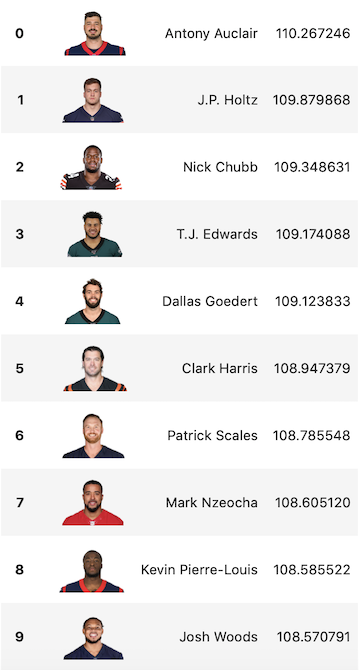

# 2. Contain ELO/Shed ELO

A player might be a good rusher or blocker, but you can't fully evaluate a special teamer without looking at the **second stage** (after the punt). For example, a player can be fast off the edge, but may not have the weight to hold their man oist punt.

Thus, we use the same ELO rating formula based on Contain ELO and Shed ELO. The proxy is **# of seconds** it takes for a kicking team player to **pass the 10 yard line**. I found that (1) movement in the y direction tends to **stagnant** or slowly switch around the 7-12 yard area and (2) there are not many players within the 1-2 yards in the direction the player is traveling when players are at the 10 yard line. This implies that players are in their **assigned lane** and have limited obstructions once pass the **10 yard** line (plus most players make it pass the 10 yard line). I drop players who don't make it past the 10 yard.

I match **containers** to the player they are **closest to over the entire period after punt.**

I then **min-max scale** the # of seconds to be between 0 and 1, and use that as the actual outcome in the ELO rating formula. 

I'm assuming a **linear relationship** between shed seconds and outcome, a different assumption from log(x) earlier. While, technically, the first few seconds matter more than latter seconds, as it allows the punt returner to get into **stride**, I think linear relationship is a **adequate & simpler fit**. The marginal improvement using more complex outcome formulas is limited.

Here are the **top 10 containers**:

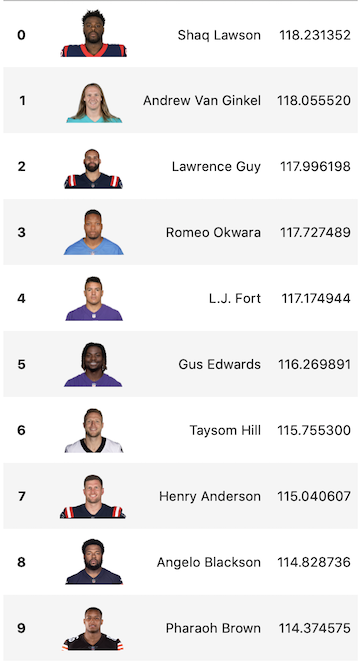

Here are the **top 10 shedders**: 

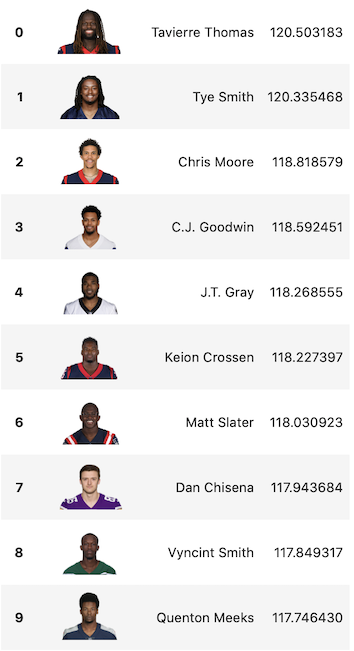

**A Problem!**

If we look at the top shedders, they are all **gunners**! From a utility perspective, this makes sense, as the gunner is the most important in **stopping the return**. However, we are comparing **apples to oranges** for different special team players. ELO should be compared between position type!

I used **heuristics** to figure out what position each player plays: gunner, vise, personal protector, wingers, long snapper, guards, etc. We then compare **apples to apples**. For example, for **personal protector**, we value the "Block Elo" the most. I identified personal protectors by measuring player **closest to the punter** at beginning and if the difference between distances of players from punters are **0.5 yard or less**, we choose the player with the **closest y value** to the punter. I created similar heuristcs for wingers, gunner, vise, long snappers, etc. Some of these are directly provided by **PFF data**.

For example, here are the best blocking personal protectors:

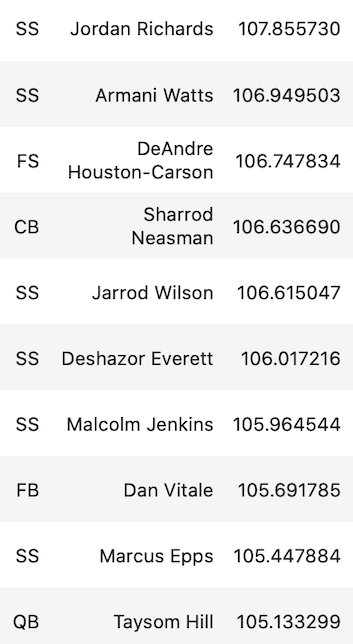

# 3. Clustering

I applied **clustering** to get subsets of players using **K-Means**. I clustered on **Rush/Contain** & **Block/Shed**. Why? Well, we could see players who can block might be strong but not blazing fast. Or vice versa. We want to identify those players who are jack of all trades, or players that specialize in blocking/shedding, who might be less expensive, fitting well into the schema. I min/max scaled the ELO ratings before clustering.

For example, here is the cluster results of Rush/Contain:

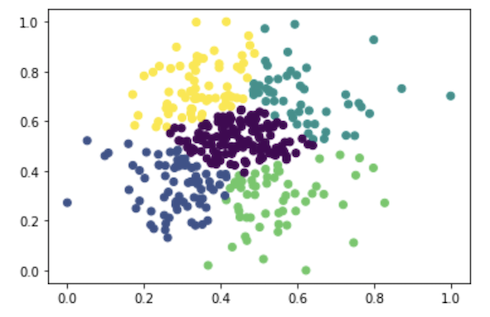

Here are some of the best players in the Sea Green Cluster aka the jack of all trades players for the returning team!

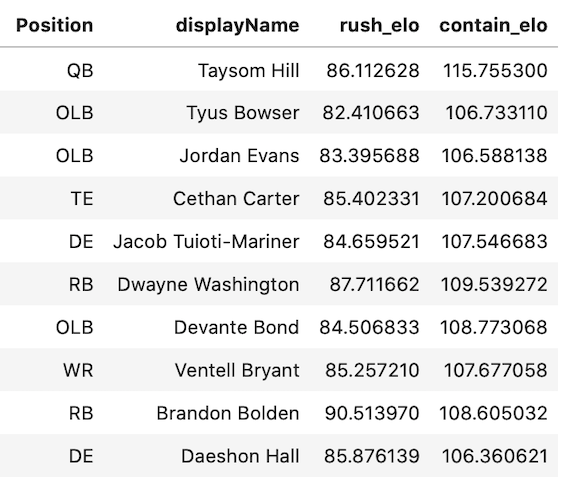

# 4. In Game Coaching Decisions
As a coach, we need to create a line-up/strategy, that **attacks the opponents weaknesses**, enhances our **strengths**, and is appropriate for the game **situation**. However, there are **1000s** of parameters to take in consideration as a coach. Can ML help us make better in game decisions? Can we literally fit those **1000** parameters?

My goal was to use **convolutions** and a **probalistic learning framework** to learn an expectation of the yards gained, and the variance(risk) of any given line up/postion.

Using this model, for example, we can simulate

    1) Lining up a overload with players of all high rush ELOs against the opponent weak blocking side
    2) Putting in more high block elo players to reduce variance/risk of a punt block in exchange for less    contain converage
    3) etc....

The average MAE for the neural net is **4.43** yards, and the average variance is **6.26** yards. The model was trained by adding each player onto a 50 * 120 grid, depending on starting location. Each starting point had information about the player ELO ratings!

# 5. Conclusion: Benefits to NFL!
**New Metrics**: (1) Use logarithmic model to evaluate **punt disruption** from punt rushers, and (2) use **time to 10 yard line** to compare shedders.

**Personnel Decisions**: Use **ELO** as a way to measure i**mpact of player**, outside of the 1 out of 100 plays (punt blocks, TD returns). Find **undervalued jack-of-all trade** players to plug and play.

**In Game Coaching Decision**s: Before the game, we can use ELO ratings to simulate line-up match ups assessing for both **expected utility** and **expected risk**
